In [95]:
import numpy as np
embeddings_dict = {}

with open("./Glove_6B/glove.6B.100d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector
np.save('./Glove_6B/wordsList', np.array(list(embeddings_dict.keys())))
np.save('./Glove_6B/wordVectors', np.array(list(embeddings_dict.values()), dtype='float32'))


In [110]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = "./Glove_6B/glove.6B.100d.txt"
tmp_file = "./word2vec.6B.100d.txt"
glove2word2vec(glove_file, tmp_file)

C:\Users\Lyus\AppData\Local\Temp\ipykernel_944\3569587879.py:7: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, tmp_file)


(400000, 100)

In [1]:
import pandas as pd #Data manipulation
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder


In [33]:
reviews = pd.read_csv('./train_data.txt', sep=' ::: ', header=None)
def removeYears(str):
    return str.split(' (')[0]
reviews.iloc[:, 3] = reviews.iloc[:, 1].apply(removeYears) + ". " + reviews.iloc[:, 3]
reviews = reviews.iloc[:, 2:]
reviews.columns = ["class", "content"]
display(reviews.head())
print("Shape: ", reviews.shape)

C:\Users\Lyus\AppData\Local\Temp\ipykernel_2496\3628053559.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  reviews = pd.read_csv('./train_data.txt', sep=' ::: ', header=None)


,class,content
0,drama,Oscar et la dame rose. Listening in to a conve...
1,thriller,Cupid. A brother and sister with a past incest...
2,adult,"Young, Wild and Wonderful. As the bus empties ..."
3,drama,The Secret Sin. To help their unemployed fathe...
4,drama,The Unrecovered. The film's title refers not o...


Shape:  (54214, 2)


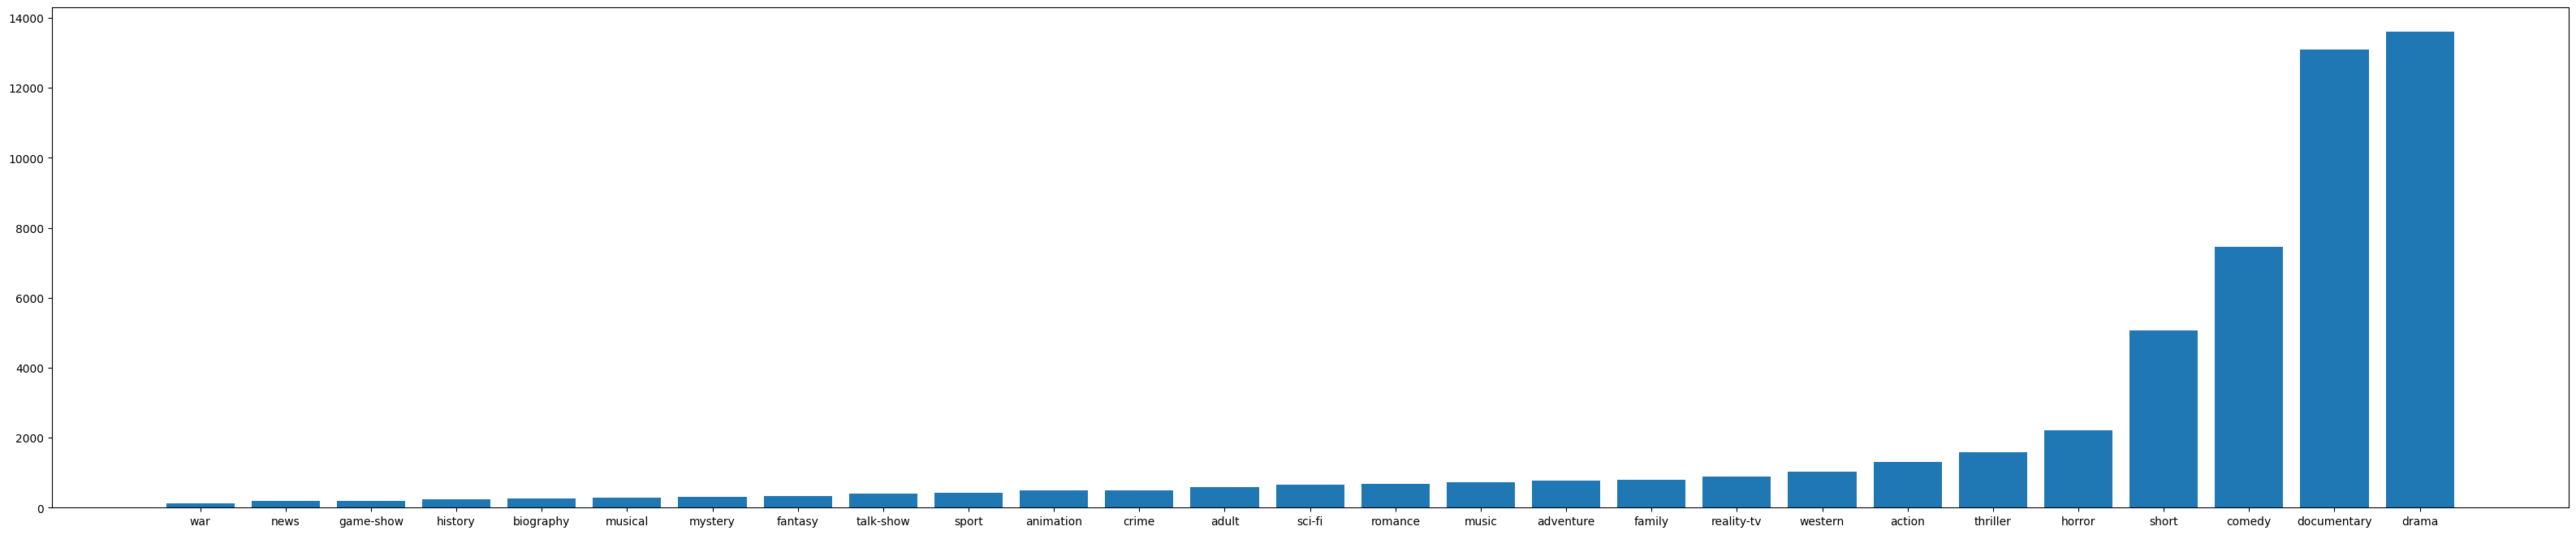

In [34]:
# plt.bar(keys, values)
keys, values = zip(*sorted(dict(reviews["class"].value_counts()).items(), key=lambda t: t[1]))
# scale up the plot
plt.figure(figsize=(40, 8))
plt.bar(keys, values)
plt.show()

In [35]:
# sort out only comedy, documdentary, drama, short, horror
reviews = reviews[reviews["class"].isin(["comedy", "documentary", "drama", "short", "horror"])]

In [36]:
reviews["class"].value_counts()

class
drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
Name: count, dtype: int64

In [37]:
lb_enc = LabelEncoder()
reviews["class"] = lb_enc.fit_transform(reviews["class"])
display(reviews.head(5))
print(reviews["class"].value_counts())
# lb_enc.inverse_transform(reviews["class"])

,class,content
0,2,Oscar et la dame rose. Listening in to a conve...
3,2,The Secret Sin. To help their unemployed fathe...
4,2,The Unrecovered. The film's title refers not o...
5,1,Quality Control. Quality Control consists of a...
6,0,"""Pink Slip"". In tough economic times Max and J..."


class
2    13613
1    13096
0     7447
4     5073
3     2204
Name: count, dtype: int64


In [38]:
# Split
X_train, X_test, y_train, y_test = train_test_split(reviews["content"], reviews["class"], test_size=0.2, random_state=0)

In [39]:
X_train

38987    Gratte-papier. On the Paris Metro, a young man...
13176    Dark Room. Dark room tells the story of a man ...
35162    In the Soviet Union. A film aimed at American ...
8053     Dead Teenager Movie. DEAD TEENAGER MOVIE is a ...
12460    A Normal Life. Follows 7 young friends over 3 ...
                               ...                        
27168    Aurelia. Romantic poet Gérard de Nerval is now...
42028    Chasing the Dragon. Life is a drug induced haz...
39800    Young Bride. A New York City assistant librari...
27808    Brezeln für den Pott. Roland Reuter, a Swabian...
3573     V Masarykových rukou. In 1928, during a state ...
Name: content, Length: 33146, dtype: object

In [40]:
# Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# nltk downleaded something into user directory in my C disk.

stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)



In [41]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [42]:
print(X_train)
print('\n')
print(X_train[0].split())

['grattepapier paris metro young man probably student nose buried book realizes young women sitting next drawing glances men car without speaking staring contrives get attention begin dialogue moves charming poetic respond stop coming'
 'dark room dark room tells story man woman waiting desired already lost moment love situation couple reflected alienated images room loss perspective causes disorientation obstructs way inner dark rooms'
 'soviet union film aimed american audiences produced soviet government 50s four sections designed make americans think soviet government progressive equally advanced us government considered pure propaganda'
 ...
 'young bride new york city assistant librarian long time friend miss margaret gordon allie smith always placed guard around leading sheltered life however recent death mother lived allie beginning feel certain void life much company people explore things world read agrees fourth setup double date eventually falls spell date charlie riggs tell

In [22]:
# Glove
wordsList = np.load('./Glove_6B/wordsList.npy').tolist()
wordsVector = np.load('./Glove_6B/wordVectors.npy')

vecIdx = wordsList.index(X_train[0].split()[1])
wordVec = wordsVector[vecIdx]
print(wordVec.shape)
print(wordVec)

(100,)
[ 0.92605  -0.22818  -0.25524   0.73997   0.50072   0.26424   0.40056
  0.56145   0.17908   0.050464  0.024095 -0.064805 -0.25491   0.29661
 -0.47602   0.24244  -0.067045 -0.46029  -0.38406  -0.3654    0.15749
  0.21118   0.018207 -0.42058   0.82612  -1.2281   -0.1881   -1.1329
  0.9173   -0.47742  -0.78411  -0.86034  -0.39816  -0.15607  -0.50674
  1.0742    0.93976  -0.091229 -0.79965   0.13812  -0.14918  -0.62778
 -0.25522  -0.52545   0.23676   0.18139  -0.59288  -0.081326  0.51924
 -0.19556   0.071476  0.57523   0.43635   0.55699  -1.4944   -2.6694
 -0.49878   0.59342   0.69801   0.13714  -0.24939   0.34214  -0.90352
 -0.51692  -0.2329   -0.040954 -0.93519   0.16596  -0.039047  0.42333
 -0.72123  -0.72504  -1.0439   -0.46385   0.082186 -0.57145   1.2457
 -0.30138  -0.99085  -0.25259   0.52881   0.14195  -0.036968  0.037708
 -1.0728   -0.43544  -0.37919   0.2541   -0.4297   -0.40406   0.15981
 -0.53575   0.98038   0.64597  -0.77094   1.1849   -0.23599  -0.40988
  0.35553   0.0

In [ ]:
# Glove 2 word2vec
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load_word2vec_format("./word2vec.6B.100d.txt")

In [23]:
# Word2Vec
from gensim.models import Word2Vec

sents = [sent.split() for sent in X_train]
w2v_model = Word2Vec(sents, vector_size=100, epochs=100)

# save w2v_model
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
w2v_model.save("./w2v_model_"+timestr+".model")

In [31]:
# load w2v_model
from gensim.models import Word2Vec
w2v_model = Word2Vec.load("./w2v_model_20231116-212214.model")

In [30]:
# TextCNN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import logging
import time
from torch.utils.data import Dataset
# torch padsequence
from torch.nn.utils.rnn import pad_sequence


batch_size = 64
filter_num = 100
epoch = 8
kernel_list = [3, 4, 5]
label_size = 5
lr = 0.001
sentence_max_size = 100

class TextCNN(nn.Module):
    def __init__(self, vec_dim, filter_num, sentence_max_size, label_size, kernel_list):
        """
        :param vec_dim: dim of vector
        :param filter_num: number of convolutional filters
        :param sentence_max_size: max length of sentence
        :param label_size: number of labels
        :param kernel_list: list of kernels
        """
        super(TextCNN, self).__init__()
        chanel_num = 1
        # nn.ModuleList is equivalent to a list of convolutions, equivalent to a list
        # nn.Conv1d() is one-dimensional convolution. in_channels: the dimension of the word vector, out_channels: the number of output channels
        # nn.MaxPool1d() is the maximum pooling, which takes the maximum value for each vector, 
        # so the kernel_size is the dimension of the vector after the convolution operation
        self.convs = nn.ModuleList([nn.Sequential(
            nn.Conv2d(chanel_num, filter_num, (kernel, vec_dim)),
            nn.ReLU(),
            # After convolution, a one-dimensional vector with a dimension of sentence_max_size - kernel + 1 is obtained
            nn.MaxPool2d((sentence_max_size - kernel + 1, 1))
        )
            for kernel in kernel_list])
        # full connection layer, because there are 2 labels
        self.fc = nn.Linear(filter_num * len(kernel_list), label_size)
        # dropout operation to prevent overfitting
        self.dropout = nn.Dropout(0.5)
        # classification
        self.sm = nn.Softmax(0)

    def forward(self, x):
        # The input of Conv2d is a four-dimensional tensor, and each dimension represents batch_size, channel, length, width respectively
        in_size = x.size(0)  # x.size(0) is the batch_size of input x

        out = [conv(x) for conv in self.convs]
        out = torch.cat(out, dim=1)
        out = out.view(in_size, -1)  # after max pooling, there are output_num numbers, and out is changed to (batch_size, output_num), -1 means adaptive
        out = F.dropout(out)
        out = self.fc(out)  # nn.Linear receives two-dimensional tensor (batch_size, output_num) as parameters, and there are as many rows as there are batches of data.
        return out
    
def train_textcnn_model(net, train_loader, epoch, lr):
    print("Start training.")
    net.train() 
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for i in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad() 
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # print info
            print("train epoch=" + str(i) + ",batch_id=" + str(batch_idx) + ",loss=" + str(loss.item() / 64))
    print('Finished training.')

def test_textcnn_model(net, test_loader):
    net.eval() 
    correct = 0
    total = 0
    test_acc = 0.0
    with torch.no_grad():
        for i, (data, label) in enumerate(test_loader):
            logging.info("test batch_id=" + str(i))
            outputs = net(data)
            _, predicted = torch.max(outputs.data, 1)  
            total += label.size(0)
            correct += (predicted == label).sum().item()
            print('Accuracy of the network on test set: %d %%' % (100 * correct / total))

def VectorizeReview(review, max_cnt, emb_size):
    # convert the review into vector
    words = review.split()
    vec = torch.zeros((max_cnt, emb_size))
    for i in range(len(words)):
        if i >= max_cnt:
            break
        if words[i] in w2v_model.wv:
            vec[i] = torch.tensor(w2v_model.wv[words[i]], dtype=torch.long)
        # if words[i] in w2v_model:
        #     vec[i] = torch.tensor(w2v_model[words[i]], dtype=torch.float32)
        else:
            vec[i] = torch.zeros(emb_size)
    return vec.unsqueeze(0)

class reviewsDataSet(Dataset):
    def __init__(self, reviews, labels, max_cnt=100, emb_size=100):
        self.reviews = reviews
        self.labels = labels
        self.max_cnt = max_cnt
        self.emb_size = emb_size
    
    def __getitem__(self, index):
        review = self.reviews[index]
        y = self.labels[index]
        # convert the words into vector
        X = VectorizeReview(review, self.max_cnt, self.emb_size)
        y = torch.tensor(y, dtype=torch.long)
        return X, y
    
    def __len__(self):
        return len(self.reviews)

In [43]:
train_dataset = reviewsDataSet(X_train, y_train, sentence_max_size, 100)    
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = reviewsDataSet(X_test, y_test, sentence_max_size, 100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=y_test.shape[0], shuffle=False)

net = TextCNN(100, filter_num, sentence_max_size, label_size, kernel_list)

In [44]:
train_textcnn_model(net, train_loader, epoch, lr)
test_textcnn_model(net, test_loader)

Start training.
train epoch=0,batch_id=0,loss=0.03683604672551155
train epoch=0,batch_id=1,loss=0.03164657577872276
train epoch=0,batch_id=2,loss=0.02899947017431259
train epoch=0,batch_id=3,loss=0.025776991620659828
train epoch=0,batch_id=4,loss=0.023528844118118286
train epoch=0,batch_id=5,loss=0.02039799839258194
train epoch=0,batch_id=6,loss=0.030867112800478935
train epoch=0,batch_id=7,loss=0.024450894445180893
train epoch=0,batch_id=8,loss=0.020655417814850807
train epoch=0,batch_id=9,loss=0.01992584578692913
train epoch=0,batch_id=10,loss=0.023896437138319016
train epoch=0,batch_id=11,loss=0.0268376674503088
train epoch=0,batch_id=12,loss=0.025723345577716827
train epoch=0,batch_id=13,loss=0.025782568380236626
train epoch=0,batch_id=14,loss=0.02217457816004753
train epoch=0,batch_id=15,loss=0.025505851954221725
train epoch=0,batch_id=16,loss=0.026447275653481483
train epoch=0,batch_id=17,loss=0.026550212875008583
train epoch=0,batch_id=18,loss=0.02432640828192234
train epoch=0,b

In [25]:
import numpy as np

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    # words_vecs = [w2v_model[word] for word in words if word in w2v_model]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

In [26]:
# check X_train
print(X_train.shape)
X_train[:5]

(33146, 100)


array([[ 3.08914214e-01, -2.20350534e-01, -1.14696193e+00,
        -1.92817748e-01,  3.05065334e-01,  8.13061297e-01,
        -5.97920537e-01, -8.45523834e-01, -1.68651551e-01,
         2.51300663e-01,  5.69724977e-01,  1.22860849e+00,
         1.66133583e-01,  3.72143596e-01, -2.36747861e-02,
         7.55639732e-01,  1.04197055e-01,  1.06581664e+00,
        -3.23275030e-01,  9.45297182e-02, -8.45433623e-02,
        -7.22023904e-01,  1.09801807e-01, -3.34849983e-01,
         4.99483943e-01, -3.94310027e-01, -2.58012414e-01,
         4.68073070e-01,  3.66231471e-01, -4.32616733e-02,
         2.36715764e-01, -6.13590717e-01,  1.03556313e-01,
         3.71010631e-01, -8.15501362e-02, -2.57387698e-01,
        -2.15561941e-01, -4.95193511e-01,  6.70109630e-01,
         1.22741163e-02,  1.35335207e-01,  7.57827997e-01,
         3.57628763e-01, -2.44180903e-01, -3.16357285e-01,
         3.36581528e-01,  1.14490116e+00, -8.32071960e-01,
        -3.05259734e-01, -4.86617565e-01,  1.44326478e-0

In [27]:
# sklearn MLPClassifier
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=5000, activation='relu', learning_rate='constant', learning_rate_init=0.01,
                        solver='sgd', verbose=10,  random_state=0, tol=1e-4)

clf.fit(X_train, y_train)

Iteration 1, loss = 1.02492434
Iteration 2, loss = 0.81734938
Iteration 3, loss = 0.78283817
Iteration 4, loss = 0.76623541
Iteration 5, loss = 0.75533994
Iteration 6, loss = 0.74660481
Iteration 7, loss = 0.73952993
Iteration 8, loss = 0.73293935
Iteration 9, loss = 0.72784939
Iteration 10, loss = 0.72143529
Iteration 11, loss = 0.71698421
Iteration 12, loss = 0.71177008
Iteration 13, loss = 0.70590562
Iteration 14, loss = 0.70069373
Iteration 15, loss = 0.69540458
Iteration 16, loss = 0.69145172
Iteration 17, loss = 0.68681404
Iteration 18, loss = 0.68068103
Iteration 19, loss = 0.67533230
Iteration 20, loss = 0.66999030
Iteration 21, loss = 0.66568510
Iteration 22, loss = 0.65903195
Iteration 23, loss = 0.65554909
Iteration 24, loss = 0.65012367
Iteration 25, loss = 0.64380856
Iteration 26, loss = 0.63892589
Iteration 27, loss = 0.63395429
Iteration 28, loss = 0.62894339
Iteration 29, loss = 0.62355603
Iteration 30, loss = 0.61982925
Iteration 31, loss = 0.61386875
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01,
              max_iter=5000, random_state=0, solver='sgd', verbose=10)

In [28]:
def evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5)):
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)
    
    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision)))
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()

Accuracy: 0.63
Auc: 0.84
Detail:
              precision    recall  f1-score   support

           0       0.52      0.58      0.55      1506
           1       0.75      0.81      0.78      2586
           2       0.65      0.63      0.64      2730
           3       0.66      0.60      0.63       434
           4       0.36      0.28      0.31      1031

    accuracy                           0.63      8287
   macro avg       0.59      0.58      0.58      8287
weighted avg       0.62      0.63      0.62      8287



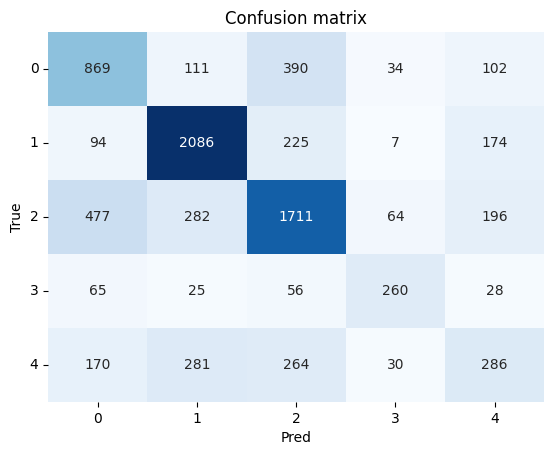

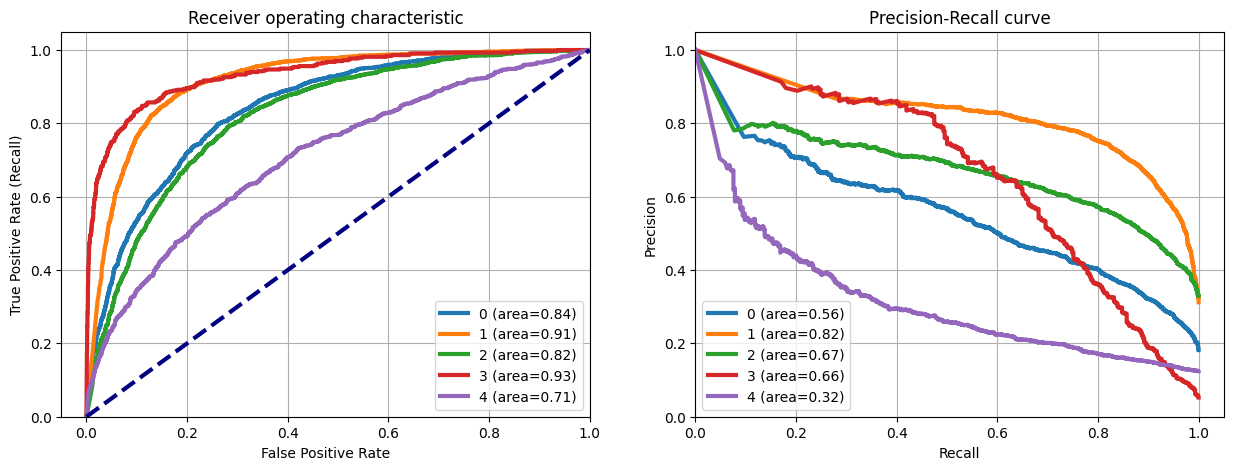

In [29]:
# predict
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

evaluate_multi_classif(y_test, y_pred, y_pred_proba)